The basics of the Non-doinated Sorting Genetic Algorithm are http://ieeexplore.ieee.org/document/996017/

In [7]:
%matplotlib inline
#Importing required modules
import math
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm

## 0. Function definition


### Individual class definition for the sorting function 

In [8]:
class Individual(object):
    p = []
    n = 0

    def __init__(self, p, n):
        self.p = p
        self.n = n

### $\prec$ operator
The dominance operation is usually defined mathematicaly as:
\begin{matrix}
    f_i(x^1) \leq f_i(x^2) && \text{for all } i \text{ in } i \in {1, 2, ..., k}\\
    f_i(x^1) < f_i(x^2) && \text{for at least one } i \text{ in } i \in {1, 2, ..., k}
\end{matrix}

In [9]:
def prec_operator(P,Q):
    # Dominance operator, returning True or False depending on the dominance of P and Q
    var = P.shape[0]
    # Dimensions between p and q must match
    if var != Q.shape[0]:
        raise ValueError("P and Q dimmensions don't match")
    # If all elements in P are smaller than those in Q, then P is dominating
    if np.sum(P < Q) == var:
        return True
    # Formal dominance operator
    elif np.sum(np.logical_or(P < Q, P == Q)) == var and np.sum(P < Q) >= 1: 
        return True
    else:
        return False

### $\texttt{fastNonDominatedSort}$ function 
Extracted from http://ieeexplore.ieee.org/document/996017/

In [126]:
def fastNonDominatedSort(P):
    # Number of variables of the problem
    var = P.shape[1]
    ps = P.shape[0] #possible solutions
    ind = []
    # DPareto front list
    F = []
    # Let's create an empty array for the 1st Pareto front
    F1 = np.empty((0,1), float) # The index of the point will be stored

    for i in range(ps):
        S_p = np.empty((0,1), float) # dominated solutions for each p and its domination count n_p for the solution 
        n_p = 0
        for j in range(ps):
            if prec_operator(P[i],P[j]): # If p dominates q in all variables it will be smaller in all variables
                S_p = np.append(S_p, j) # Add q to the set of solutions dominated by p
            elif prec_operator(P[j],P[i]):
                n_p += 1 # Increment the domination counter of p
        if n_p == 0: # p belongs to the first front
    #         p_rank = 1 #This is not really necessary
            F1 = np.append(F1, i) #Let's include the rank after the two main variables
        ind.append(Individual(S_p, n_p))
    # Store the first frontier in the frontiers list
    F.append(F1)

    front = 0

    while len(F[front]) != 0:
        Q = np.empty((0,1), float) # used to store the members of the next front
        for i in range(F[front].size): 
            for j in range(ind[int(F[front][i])].p.size):
                ind[int(ind[int(F[front][i])].p[j])].n -= 1 # reduce the domination counter by 1
                if ind[int(ind[int(F[front][i])].p[j])].n == 0: # q belongs to the next front
#                     q_rank = front + 2 #This is not really necessary
                    Q = np.append(Q, int(ind[int(F[front][i])].p[j]))
        front += 1
        F.append(Q)

    # Let's create the values of the points instead index
    PF = []
    for i in range(front):
        PF.append(P[F[i].astype(int).tolist()])
        
    return PF, F

### $\texttt{fastNonDominatedSort}$ function 
Extracted from http://ieeexplore.ieee.org/document/996017/

In [11]:
def crowdingDistanceAssignment(PF):
    l = PF.shape[0] # number of solutions in PF
    m = PF.shape[1] # number of objective functions
    I = np.zeros((l,m)) # preallocate distance
    for i in range(m):
        temp = PF[np.argsort(PF[:,i])] # sort by using objective value m
        I[0,i] = float('inf') # boundary points are selected as infinite so they're always choosen
        I[-1,i] = float('inf')
        for j in range(0,l-2): # for the other points()
            I[j+1,i] = (temp[j+2,i] - temp[j,i])/(temp.max(axis=0)[i]-temp.min(axis=0)[i])    
    return I

### $\prec_n$ sorting
Extracted from http://ieeexplore.ieee.org/document/996017/ where it is stated as:
$$
i \prec_n j \text{ if any of these is true }
\begin{Bmatrix}
    i_{rank} < j_{rank} \\
    i_{rank} == j_{rank} \ \ \mathbf{ and } \ \ i_{dist} > j_{dist}
\end{Bmatrix}
$$

In [12]:
def crowdingComparison(i_rank,j_rank,i_dist,j_dist):
    if i_rank < j_rank:
        return True
    elif i_rank == j_rank and i_dist > j_dist:
        return True
    else:
        return False

### $\texttt{tournament}$ function
The algorithm for the binary tournament selection has been coded following: http://www.tik.ee.ethz.ch/file/6c0e384dceb283cd4301339a895b72b8/TIK-Report11.pdf

In [386]:
# P 
Q = np.copy(P)
N = len(P)

In [409]:
R = np.concatenate((P,Q))
PF, F = fastNonDominatedSort(R)
nP = []
i = 0

In [414]:
while len(nP) + len(PF[i]) <= N:
#     I = crowdingDistanceAssignment(PF[i])
    for j in range(len(PF[i])):
        nP.append(PF[i][j].tolist())
    i += 1

In [417]:
I = crowdingDistanceAssignment(PF[i])
I

array([[       inf,        inf],
       [0.2       , 0.16666667],
       [0.2       , 0.16666667],
       [0.3       , 0.33333333],
       [0.3       , 0.33333333],
       [0.2       , 0.33333333],
       [0.2       , 0.33333333],
       [0.3       , 0.16666667],
       [0.3       , 0.16666667],
       [       inf,        inf]])

In [373]:
PFns = np.concatenate(PF) #no sorted paretoFront data

matingPool = np.zeros(N)

PFnumber = np.zeros(len(PFns))
count = 0
for i in range(len(PF)):
    for j in range(len(PF[i])):
        PFnumber[count] = i
        count += 1

ind1 = np.random.choice(np.linspace(0,len(PFns)-1,len(PFns)),1).astype(int)
ind2 = np.random.choice(np.linspace(0,len(PFns)-1,len(PFns)),1).astype(int)

while ind1 == ind2:
    ind1 = np.random.choice(np.linspace(0,len(PFns)-1,len(PFns)),1).astype(int)
    ind2 = np.random.choice(np.linspace(0,len(PFns)-1,len(PFns)),1).astype(int)

if 

In [376]:
PFnumber[ind1]

array([2.])

In [377]:
PFnumber[ind2]

array([1.])

In [378]:
I

array([[       inf,        inf],
       [0.375     , 0.55555556],
       [0.875     , 0.77777778],
       [       inf,        inf]])

In [ ]:
def binary_tournament(P, Q, N)

## Examples

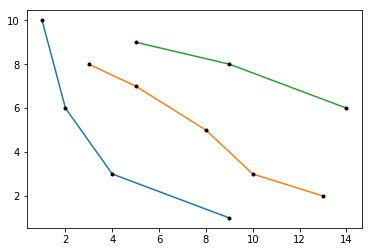

In [188]:
P = np.array([[1,10],[2,6],[3,8],[4,3],[5,7],[5,9],[8,5],[9,1],[10,3],[9,8],[13,2],[14,6]])

PF, F = fastNonDominatedSort(P)
I = crowdingDistanceAssignment(PF[0])

for i in range(len(PF)):
    plt.plot(PF[i][:,0],PF[i][:,1])
    plt.plot(PF[i][:,0],PF[i][:,1],'k.')

## Feature testing

In [128]:
funNo = 2

In [129]:
def fun(x,y,no):
    #Attribute of the function to know the real number of callings to the function
    fun.counter += x.shape[0]/funNo
    if no == 0:
        return 4*x**2+4*y**2
    if no == 1:
        return (x-5)**2+(y-5)**2

In [130]:
def const(x,y,no):
    #Let's use Python notation so the first equation will be no=0...
    if no == 0:
        return (x-5)**2+y**2
    if no == 1:
        return (x-8)**2+(y+3)**2

In [131]:
constVal = [25, 7.7]
compMode = ['leq', 'geq']

In [132]:
x_low = 0
x_high = 5
y_low = 0
y_high = 3

In [133]:
def constrainedPts(points, const, constVal, compMode):
    #Let's create a function that checks if any of the points is constrained and returns its boolean
    boolMat = np.zeros([len(constVal), points.shape[0]])
    #Let's get the points that are valid under the constraints
    for i in range(len(constVal)):
        if compMode[i] == 'leq':
            boolMat[i,:] = np.logical_or(const(points[:,0], points[:,1], i) < constVal[i], const(points[:,0], points[:,1], i) == constVal[i])
        elif compMode[i] == 'less':
            boolMat[i,:] = const(points[:,0], points[:,1], i) < constVal[i]
        elif compMode[i] == 'geq':
            boolMat[i,:] = np.logical_or(const(points[:,0], points[:,1], i) > constVal[i], const(points[:,0], points[:,1], i) == constVal[i])
        elif compMode[i] == 'greater':
            boolMat[i,:] = const(points[:,0], points[:,1], i) > constVal[i]
        elif compMode[i] == 'eq':
            boolMat[i,:] = const(points[:,0], points[:,1], i) == constVal[i]
        else:
            raise RuntimeError('Bad comparison mode matrix')
    #Once all the comparisons are made, the output should be an OR array along the boolMat
    return np.logical_or.reduce(np.logical_not(boolMat))

## MonteCarlo bunch of points

In [135]:
#Number of used points
noPoints = 500

#Get a random set of points
x = x_low+np.random.rand(noPoints)*(x_high-x_low)
y = y_low+np.random.rand(noPoints)*(y_high-y_low)

#Make a copy of the points X-Y to extract the valid ones
valid_x = np.copy(x)
valid_y = np.copy(y)
#Let's get the points that are valid under the constraints
for i in range(len(constVal)):
    if compMode[i] == 'leq':
        boolMat = np.logical_or(const(valid_x, valid_y, i) < constVal[i], const(valid_x, valid_y, i) == constVal[i])
    elif compMode[i] == 'less':
        boolMat = const(valid_x, valid_y, i) < constVal[i]
    elif compMode[i] == 'geq':
        boolMat = np.logical_or(const(valid_x, valid_y, i) > constVal[i], const(valid_x, valid_y, i) == constVal[i])
    elif compMode[i] == 'greater':
        boolMat = const(valid_x, valid_y, i) > constVal[i]
    elif compMode[i] == 'eq':
        boolMat = const(valid_x, valid_y, i) == constVal[i]
    else:
        print('Bad comparison mode matrix')
    valid_x = valid_x[boolMat] 
    valid_y = valid_y[boolMat]

#Evaluate the function for all points and for the valid ones
valid_values = np.zeros([len(valid_x), funNo])
all_values = np.zeros([len(x), funNo])

#Function attribute counter
fun.counter = 0

for i in range(funNo):
    valid_values[:,i] = fun(valid_x, valid_y, i)

#True number of calllings to the function
MC_eval = fun.counter

for i in range(funNo):
    all_values[:,i] = fun(x, y, i)

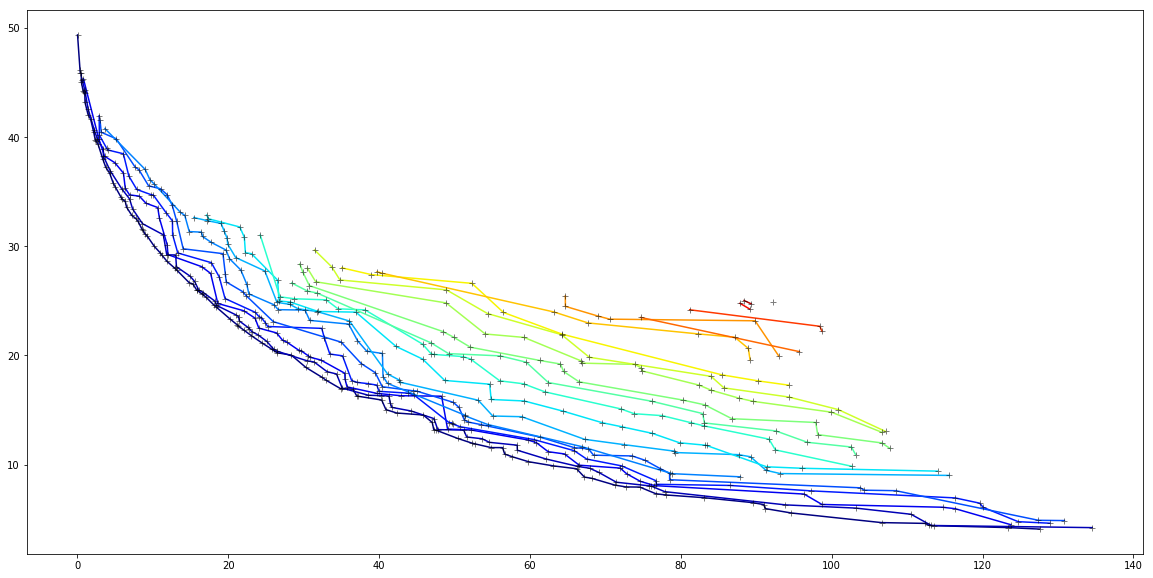

In [136]:
PF, _ = fastNonDominatedSort(all_values)
I = crowdingDistanceAssignment(PF[0])

fig, ax0 = plt.subplots(1, figsize=(20,10))
color = cm.jet(np.linspace(0,1,len(PF)))
for i in range(len(PF)):
    plt.plot(PF[i][np.argsort(PF[i][:,0]),0],PF[i][np.argsort(PF[i][:,0]),1], c = color[i])
plt.plot(all_values[:,0],all_values[:,1],'k+', alpha=0.5)

Text(0.5,1,'First objective function')

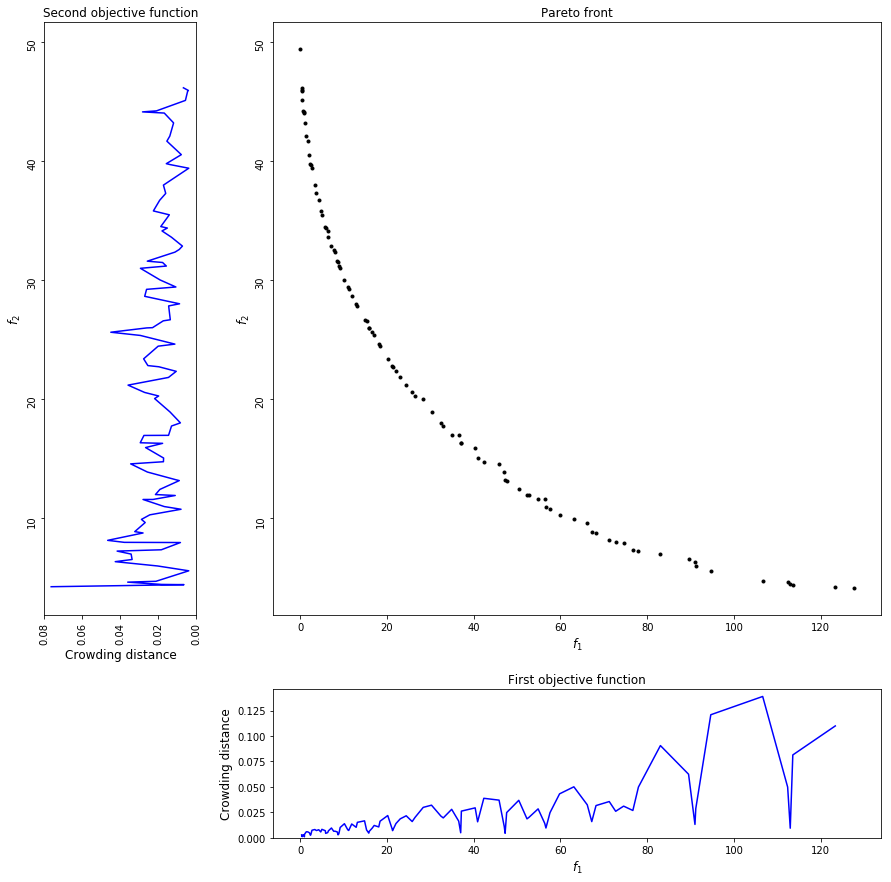

In [137]:
fig = plt.figure(figsize=(15, 15))
grid = plt.GridSpec(2, 2, wspace=0.2, hspace=0.2, width_ratios=[1, 4], height_ratios=[4, 1])
axUL = fig.add_subplot(grid[0]) #upper left
axLR = fig.add_subplot(grid[3]) #lower right
axUR = fig.add_subplot(grid[1]) #upper right

axUR.plot(PF[0][:,0],PF[0][:,1], 'k.')
axUR.tick_params(axis='y', rotation=90)
axUR.set_xlabel('$f_1$',fontsize=12)
axUR.set_ylabel('$f_2$',fontsize=12)
axUR.set_title('Pareto front')

axUL.plot(I[:,1],PF[0][np.argsort(PF[0][:,0]),1],'b')
axUL.set_xlim((0,None))
axUL.set_xlim(axUL.get_xlim()[::-1])
axUL.set_ylim(axUR.get_ylim())
axUL.tick_params(axis='x', rotation=90)
axUL.tick_params(axis='y', rotation=90)
axUL.set_xlabel('Crowding distance', fontsize=12)
axUL.set_ylabel('$f_2$',fontsize=12)
axUL.set_title('Second objective function')

axLR.plot(PF[0][np.argsort(PF[0][:,0]),0],I[:,0],'b')
axLR.set_xlim(axUR.get_xlim())
axLR.set_ylim((0,None))
axLR.set_xlabel('$f_1$',fontsize=12)
axLR.set_ylabel('Crowding distance',fontsize=12)
axLR.set_title('First objective function')

## Main loop

In [154]:
# Function attribute to count callings (future CFD simulations)
fun.counter = 0
# Number of individuals per generation
N = 100
# Generation list (new generations will be appended at the end)
P = []
# Function evaluation (new evaluations will be appended at the end)
funEval = []
# Current generation
p = 0
# Let's create the first generation with random individuals
# Transpose is used to have the number of individuals in rows and coordinates in columns
P.append(np.array([x_low+np.random.rand(N)*(x_high-x_low),y_low+np.random.rand(N)*(y_high-y_low)]).T)
# Constrained values will be replaced, given new random numbers in its places
while sum(constrainedPts(P[p], const, constVal, compMode)) != 0:
    # The points where the constraints are not fulfilled ...
    boolMat = constrainedPts(P[p], const, constVal, compMode)
    # ... are replaced with random numbers
    for i in np.argwhere(boolMat == True):
        P[p][i] = np.array([x_low+np.random.rand(1)*(x_high-x_low),y_low+np.random.rand(1)*(y_high-y_low)]).T
# Preallocation of space for the temporary function evaluation
fE = np.zeros((N,funNo))
# Evaluation of the functions 
for i in range(funNo):
    fE[:,i] = fun(P[p][:,0], P[p][:,1], i)
# Append the temporary function evaluation to the list
funEval.append(fE)
# Fitness evaluation of the population according to Pareto front rules
_, F = fastNonDominatedSort(funEval[p])

In [155]:
i = 0


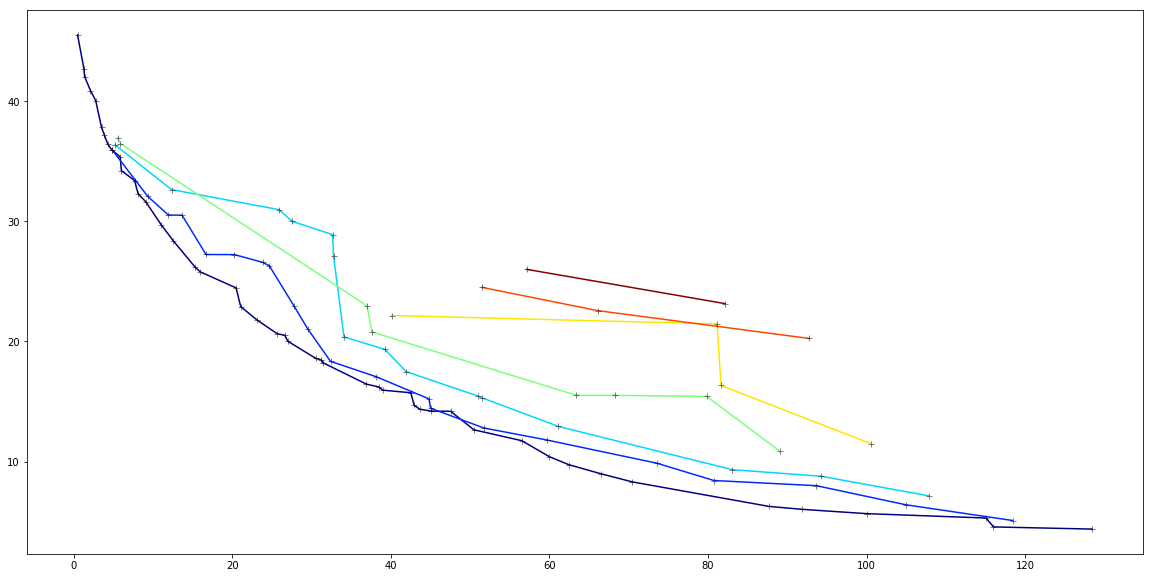

In [157]:
fig, ax0 = plt.subplots(1, figsize=(20,10))
color = cm.jet(np.linspace(0,1,len(F)-1))
for i in range(len(F)-1):
    plt.plot(np.sort(funEval[p][F[i].astype(int).tolist()][:,0]),funEval[p][F[i].astype(int).tolist()][np.argsort(funEval[p][F[i].astype(int).tolist()][:,0]),1], c = color[i])
plt.plot(funEval[0][:,0],funEval[0][:,1],'k+', alpha=0.5)

In [116]:
PF

[array([[ 42.42351844,  14.56119037],
        [ 71.36833618,   8.56247795],
        [105.95545214,   5.33038102],
        [  0.38758423,  45.72520867],
        [ 24.77645276,  21.55607005],
        [ 31.62916612,  18.53325972],
        [  2.15311293,  41.30934898],
        [ 71.35578302,  10.3199681 ],
        [  6.84102916,  34.87544037],
        [ 43.66247144,  14.19175245],
        [ 88.20966045,   7.30786367],
        [ 91.89830037,   6.13342777],
        [ 33.57927473,  17.59360161],
        [ 10.23223125,  31.16809383],
        [ 37.73418438,  16.49493923],
        [  1.48976448,  42.32944641],
        [ 18.99580532,  23.98769042],
        [  1.08379796,  43.89244708],
        [ 37.87809993,  16.07481222],
        [ 51.52677618,  12.50496845],
        [ 54.54947069,  11.42689083],
        [ 76.67821692,   8.47782722],
        [  0.77107424,  44.73883922],
        [ 13.28925589,  27.54756942],
        [ 26.38710136,  20.9524962 ],
        [ 26.41835371,  20.28775069],
        [ 12

In [76]:
P[p]

array([[4.45957824e+00, 1.29006933e+00],
       [4.36157134e+00, 2.22943702e+00],
       [4.35437950e+00, 1.28502305e+00],
       [1.00000000e+00, 2.00000000e+00],
       [1.33357018e+00, 2.85450176e-01],
       [1.63459018e+00, 1.38567274e+00],
       [4.67799300e+00, 2.26785736e+00],
       [1.14273831e+00, 2.39282341e+00],
       [6.09674805e-01, 2.00120176e+00],
       [4.90197513e+00, 9.45731515e-01],
       [2.73642085e+00, 4.23511991e-01],
       [4.51268069e+00, 1.88472687e+00],
       [4.74270148e+00, 1.28337281e+00],
       [9.96451077e-01, 2.22018658e+00],
       [1.58180650e+00, 2.53661526e+00],
       [4.07326874e+00, 1.51395462e+00],
       [3.61486184e+00, 1.88232515e+00],
       [1.67162089e+00, 1.58861197e-01],
       [1.23978949e-01, 1.72894369e+00],
       [4.11683570e+00, 1.03729338e+00],
       [2.03856152e+00, 6.97463196e-01],
       [5.83032821e-01, 2.35294372e+00],
       [1.56618824e+00, 9.37677252e-01],
       [1.94177229e+00, 2.20607159e+00],
       [3.752719